# Описание
## Важно
В процессе не хватало оперативки коллаба, поэтому обучающую выборку собирал по частям. Файлы df_train2 и df_test2 можно найти по ссылке https://drive.google.com/drive/folders/19Y1X6oDiUlqnnK6I6nkK1AigRhsBJqBS?usp=sharing.

## Решение
Идея состояла в том, что бы перед интересующим нас месяцем описать состояние вагона. Была сформирован датасет для четырех последних месяцев, размером примерно 130 000.
Сгенерированные признаки:
 - различные временные интервалы(возраст вагона, время до ПР, время с последнего ремонта, время ло истечения срока эксплоатации);
 - обратил внимание, что вагоны стоят несколько дней на одном месте, сгенерировал признак - сумма дней простоя, оказался неплохим;
 - куммулятивные признаки (кол-во ремонтов, кол-во различных типов станций, кол-во различных типов грузов и т.д.)
 - так же добавил признак - кол-во ухода в ремонт на определенной дороге;
 - признаки из таблиц без изменений.

 ## Наблюдения
 На визуализацию немного не хватило времени, поэтому опишу наблюдения так.
 В топе по важности оказались вполне ожидаемые признаки - оставшийся пробег, время до планового ремонта, время прошедшее с последнего ремонта.
 Так же в топе находились и интересные:
  - количество прошедших плановых ремонтов, возможно отражает износ вагона;
  - тип груза, возможно, некоторые типы грузов повышают вероятность поломки;
  - дни простоя, возможно, мелки поломки, трудные условия погрузки-разгрузки;
  - количество уходов в ремонт с определенной дороги, возможно, есть сложные участки дороги.
  Все пункты стоят более детального изучения.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import mean_absolute_error, roc_curve,accuracy_score, roc_auc_score, confusion_matrix, f1_score, log_loss
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [ ]:
# функция изменения типов

def down(df):
  for column, dtype in zip(df.columns, df.dtypes):
    dtype = str(dtype)
    # column_data = df[column]
    if any([_ in dtype for _ in ('Int', 'int', 'float')]):
      column_min, column_max = df[column].min(), df[column].max()
      if 'int' or 'Int' in dtype:
        # if (column_min > np.iinfo(np.int8).min) and (column_max < np.iinfo(np.int8).max):
        #   df[column] = df[column].astype(np.int8)
        if (column_min > np.iinfo(np.int16).min) and (column_max < np.iinfo(np.int16).max):
          df[column] = df[column].astype(np.int16)
        elif (column_min > np.iinfo(np.int32).min) and (column_max < np.iinfo(np.int32).max):
          df[column] = df[column].astype(np.int32)
        else:
          df[column] = df[column].astype(np.int64)

      else:
        # if (column_min > np.finfo(np.float16).min) and (column_max < np.finfo(np.float16).max):
        #   df[column] = df[column].astype(np.float16)
        if (column_min > np.finfo(np.float32).min) and (column_max < np.finfo(np.float32).max):
          df[column] = df[column].astype(np.float32)
        else:
          df[column] = df[column].astype(np.float64)

    # elif dtype == 'object':
    #   df[column] = df[column].astype('category')

  return df


# Данные

In [ ]:
PATH = '/content/drive/My Drive/datawagon'

In [ ]:
y_train = pd.read_csv(PATH +'/target/y_train.csv').convert_dtypes()
y_test = pd.read_csv(PATH +'/test/target/y_test.csv').convert_dtypes()

In [ ]:
y_train = pd.concat([y_train, y_test])
del y_test

In [ ]:
# данные по дислокации
dislok = pd.read_parquet(PATH + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(PATH + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(PATH + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param = pd.read_parquet(PATH + '/wag_params.parquet').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(PATH + '/tr_rems.parquet').convert_dtypes()
# справочник грузов
freight = pd.read_parquet(PATH + '/freight_info.parquet').convert_dtypes()
# справочник станций
stations = pd.read_parquet(PATH + '/stations.parquet').convert_dtypes()
# справочник станций
kti = pd.read_parquet(PATH + '/kti_izm.parquet').convert_dtypes()

In [ ]:
dislok.shape

(6250933, 16)

In [ ]:
dislok = dislok.drop_duplicates()

In [ ]:
# февраль

PATH2 = '/content/drive/My Drive/datawagon/test'

# данные по дислокации
dislok_feb = pd.read_parquet(PATH2 + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem_feb = pd.read_parquet(PATH2 + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob_feb = pd.read_parquet(PATH2 + '/wagons_probeg_ownersip.parquet').convert_dtypes()
 # параметры вагона
wag_param_feb = pd.read_parquet(PATH2 + '/wag_params.parquet').convert_dtypes()
# текущие ремонты вагонов
tr_rem_feb = pd.read_parquet(PATH2 + '/tr_rems.parquet').convert_dtypes()
# справочник грузов
freight_feb = pd.read_parquet(PATH2 + '/freight_info.parquet').convert_dtypes()
# справочник станций
stations_feb = pd.read_parquet(PATH2 + '/stations.parquet').convert_dtypes()
# справочник станций
kti_feb = pd.read_parquet(PATH2 + '/kti_izm.parquet').convert_dtypes()

In [ ]:
dislok_feb.shape

(977304, 16)

#### Объединим таблицы

In [ ]:
dislok = pd.concat([dislok, dislok_feb])
# данные по текущим ремонтам
pr_rem = pd.concat([pr_rem, pr_rem_feb])
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.concat([wag_prob, wag_prob_feb])
 # параметры вагона
wag_param = pd.concat([wag_param, wag_param_feb])
# текущие ремонты вагонов
tr_rem = pd.concat([tr_rem, tr_rem_feb])
# справочник грузов
freight = pd.concat([freight, freight_feb])
# справочник станций
stations = pd.concat([stations, stations_feb])
# справочник станций
kti = pd.concat([kti, kti_feb])

del dislok_feb, pr_rem_feb, wag_prob_feb, wag_param_feb, tr_rem_feb, freight_feb, stations_feb, kti_feb

In [ ]:
wag_param.drop_duplicates(keep='first',inplace=True)
freight.drop_duplicates(keep='first',inplace=True)
stations.drop_duplicates(keep='first',inplace=True)

### Таргет

In [ ]:
y_train['month'] = pd.to_datetime(y_train['month'])

### Генерация признаков и подготовка выборки

In [ ]:
dislok = dislok.sort_values(['wagnum', 'plan_date']).reset_index(drop=True)

In [ ]:
# подготовка kti

kti = kti.sort_values(['wagnum',	'operation_date_dttm'])

cols_inter = [
    'mileage_all',
    'axl1_l_w_flange',
       'axl1_r_w_flange', 'axl2_l_w_flange', 'axl2_r_w_flange',
       'axl3_l_w_flange', 'axl3_r_w_flange', 'axl4_l_w_flange',
       'axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim', 'axl2_l_w_rim',
       'axl2_r_w_rim', 'axl3_l_w_rim', 'axl3_r_w_rim', 'axl4_l_w_rim',
       'axl4_r_w_rim']

for col in cols_inter:
    kti[col] = kti[col].astype('float64')

for col in cols_inter:
  kti[col] = kti.groupby('wagnum')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

kti['operation_date_dttm'] = pd.to_datetime(kti['operation_date_dttm'])
kti = kti.fillna(-1)
kti = down(kti)

In [ ]:
# подготовка stations
cols = ['st_border_sign', 'st_sea_sign', 'st_river_sign',
       'st_car_sign', 'st_ferry_sign', 'st_freigh_sign']

for col in cols:
    stations[col] = stations[col].astype('int')

stations = down(stations)

In [ ]:
# изменение типов
for col in dislok.columns:
    try:
        dislok[[col]] = down(dislok[[col]])
    except:
        continue

In [ ]:
wag_param.drop(['date_iskl'], axis=1, inplace=True)
wag_prob = wag_prob.drop(['ost_prob', 'month', 'ownership_type', 'rod_id'], axis=1)

In [ ]:
def features(date, wag_param_copy, wag_prob_copy, pr_rem_copy, tr_rem_copy, kti_copy, freight_copy, stations_copy):
  # оставим данные только до заданной даты
  df = dislok[dislok['plan_date']<date]

  # дни простоя
  df['outage_days'] = df.groupby('wagnum')['ost_prob'].transform(lambda x: x.eq(x.shift()))
  df['outage_days'] = df.groupby('wagnum')['outage_days'].transform('sum')

  # kti
  df = df.merge(kti_copy, how='left', left_on=['wagnum', 'plan_date'], right_on=['wagnum', 'operation_date_dttm'])
  df.drop(['operation_date_dttm'], axis=1, inplace=True)
  for col in ['axl1_l_w_flange', 'axl1_r_w_flange', 'axl2_l_w_flange',
       'axl2_r_w_flange', 'axl3_l_w_flange', 'axl3_r_w_flange',
       'axl4_l_w_flange', 'axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim',
       'axl2_l_w_rim', 'axl2_r_w_rim', 'axl3_l_w_rim', 'axl3_r_w_rim',
       'axl4_l_w_rim', 'axl4_r_w_rim']:
      df[col] = df.groupby(['wagnum'])[col].apply(lambda x: x.ffill().bfill())
  del kti_copy

  # количество плановых ремонтов
  pr_rem_copy = pr_rem_copy[['wagnum', 'rem_month', 'st_id_send', 'road_id_send', 'kod_vrab']]
  df = df.merge(pr_rem_copy[['wagnum', 'rem_month']], how='left', left_on=['wagnum', 'plan_date'], right_on=['wagnum', 'rem_month'])
  df['plan_rem_count'] = df.groupby(['wagnum'])['rem_month'].transform('count')
  df.drop(['rem_month'], axis=1, inplace=True)

  #самые опасные дороги
  roads = pr_rem_copy['road_id_send'].value_counts().to_frame().reset_index().rename(columns={'index':'id_road_disl', 'road_id_send':'count_rem_road'})
  df = df.merge(roads, how='left', left_on=['id_road_disl'], right_on=['id_road_disl'])
  del roads, pr_rem_copy

  # грузы
  freight_copy = down(freight_copy)
  df = df.merge(freight_copy, how='left', left_on=['fr_id'], right_on=['fr_id'])
  del freight_copy
  for i in ['skoroport', 'naval', 'nasip', 'naliv', 'openvagons', 'soprovod', 'smerz']:
    df[f'sum_{i}'] = df.groupby(['wagnum'])[i].transform('sum')

  # станции
  df = df.merge(stations_copy,
                how='left', left_on=['st_id_dest', 'id_road_dest'], right_on=['st_id', 'road_id'])

  df.drop(['st_id', 'road_id'], axis=1, inplace=True)
  stations_copy = stations_copy.rename(columns={k:f'send_{k}' for k in cols})
  df = df.merge(stations_copy,
                how='left', left_on=['st_id_send', 'id_road_send'], right_on=['st_id', 'road_id'])
  df.drop(['st_id', 'road_id'], axis=1, inplace=True)

  cols = ['st_border_sign', 'st_sea_sign', 'st_river_sign',
       'st_car_sign', 'st_ferry_sign', 'st_freigh_sign']

  del stations_copy
  for i in cols:
    df[f'sum_{i}'] = df.groupby(['wagnum'])[i].transform('sum')

  for i in [f'send_{k}' for k in cols]:
    df[f'sum_{i}'] = df.groupby(['wagnum'])[i].transform('sum')
  # текущие ремонты
  tr_rem_copy = tr_rem_copy[['wagnum', 'rem_month', 'road_id_send', 'gr_probeg', 'por_probeg']]
  tr_rem_copy.sort_values(['wagnum', 'rem_month'], inplace=True)
  tr_rem_copy['gr_probeg'] = tr_rem_copy.groupby(['wagnum'])['gr_probeg'].apply(lambda x: x.ffill().bfill())
  tr_rem_copy['por_probeg'] = tr_rem_copy.groupby(['wagnum'])['por_probeg'].apply(lambda x: x.ffill().bfill())
  tr_rem_copy = tr_rem_copy.fillna(-1)
  tr_rem_copy = down(tr_rem_copy)

  df= df.merge(tr_rem_copy[['wagnum', 'rem_month', 'gr_probeg', 'por_probeg']], how='left', left_on=['wagnum', 'plan_date'], right_on=['wagnum', 'rem_month'])
  df['gr_probeg'] = df.groupby(['wagnum'])['gr_probeg'].apply(lambda x: x.ffill().bfill())
  df['por_probeg'] = df.groupby(['wagnum'])['por_probeg'].apply(lambda x: x.ffill().bfill())
  df['tr_rem_count'] = df.groupby(['wagnum'])['rem_month'].transform('count')
  df.drop(['rem_month'], axis=1, inplace=True)
  roads = tr_rem_copy['road_id_send'].value_counts().to_frame().reset_index().rename(columns={'index':'id_road_disl', 'road_id_send':'count_tr_rem_road'})
  df = df.merge(roads, how='left', left_on=['id_road_disl'], right_on=['id_road_disl'])
  del tr_rem_copy, roads
  # расположение вагонов перед месяцем таргетом
  df = df[df.groupby('wagnum')['plan_date'].apply(lambda x: x==x.max())]

  # заменим пропущенные даты капитального и деповского ремонта на дату производства вагона
  wag_param_copy.tippogl = wag_param_copy.tippogl.fillna(-1)
  wag_param_copy = down(wag_param_copy)
  df = df.merge(wag_param_copy, how='left', left_on=['wagnum'], right_on=['wagnum'])
  del wag_param_copy

  df.loc[df['date_kap'].isna(), 'date_kap'] = df.loc[df['date_kap'].isna(), 'date_build']
  df.loc[df['date_dep'].isna(), 'date_dep'] = df.loc[df['date_dep'].isna(), 'date_build']

  # количество дней после ремонтов
  df['kap_days'] = df['plan_date'] - df['date_kap']
  df['dep_days'] = df['plan_date'] - df['date_dep']

  df['kap_days'] = df['kap_days'].dt.days
  df['dep_days'] = df['dep_days'].dt.days

  # количество дней до планового
  df['plan_days'] = df['date_pl_rem'] - df['plan_date']
  df['plan_days'] = df['plan_days'].dt.days

  # количество до истечения срока службы
  df['srok_sl_days'] = df['srok_sl'] - df['plan_date']
  df['srok_sl_days'] = df['srok_sl_days'].dt.days

  # возраст
  df['age_days'] = df['srok_sl'] - df['date_build']
  df['age_days'] = df['age_days'].dt.days
  df.drop(['date_build', 'srok_sl'], axis=1, inplace=True)

  # тип владения
  wag_prob_copy = down(wag_prob_copy)
  df = df.merge(wag_prob_copy, how='left', left_on=['wagnum', 'plan_date'], right_on=['wagnum', 'repdate'])
  df.drop(['repdate', 'date_kap', 'date_dep', 'date_pl_rem'], axis=1, inplace=True)
  del wag_prob_copy

  for col in df.columns:
    try:
      df[[col]] = down(df[[col]])
    except:
      continue

  return df

In [ ]:
# доп функция для станций
#  в коллабе не хватало оперативки чтобы всё вместе считать
def features_st(date, stations_copy):
  # оставим данные только до заданной даты
  df = dislok[dislok['plan_date']<date]

  # станции
  df = df.merge(stations_copy,
                how='left', left_on=['st_id_dest', 'id_road_dest'], right_on=['st_id', 'road_id'])

  df.drop(['st_id', 'road_id'], axis=1, inplace=True)
  cols = ['st_border_sign', 'st_sea_sign', 'st_river_sign',
       'st_car_sign', 'st_ferry_sign', 'st_freigh_sign']
  stations_copy = stations_copy.rename(columns={k:f'send_{k}' for k in cols})
  df = df.merge(stations_copy,
                how='left', left_on=['st_id_send', 'id_road_send'], right_on=['st_id', 'road_id'])
  df.drop(['st_id', 'road_id'], axis=1, inplace=True)
  del stations_copy
  for i in cols:
    df[f'sum_{i}'] = df.groupby(['wagnum'])[i].transform('sum')

  for i in [f'send_{k}' for k in cols]:
    df[f'sum_{i}'] = df.groupby(['wagnum'])[i].transform('sum')

  # расположение вагонов перед месяцем таргетом
  df = df[df.groupby('wagnum')['plan_date'].apply(lambda x: x==x.max())]

  for col in df.columns:
    try:
      df[[col]] = down(df[[col]])
    except:
      continue

  return df

In [ ]:
%%time
try:
    df = pd.read_csv(PATH + '/df_train2.csv')
except:
    df = pd.DataFrame()
    for month in tqdm(['2022-11-01', '2022-12-01','2023-01-01', '2023-02-01']):
        print(month)
        temp = features(month, wag_param, wag_prob, pr_rem, tr_rem, kti, freight, stations)
        Y = y_train[y_train['month']==month]
        temp = temp.merge(Y[['wagnum','target_month','target_day']], how='left', left_on=['wagnum'], right_on=['wagnum'])
        temp = temp[~temp['target_month'].isna()]
        df = pd.concat([df, temp])
        del temp


CPU times: user 844 ms, sys: 65.5 ms, total: 910 ms
Wall time: 1.46 s


In [ ]:
# код для объединения
# df_st = pd.DataFrame()
# for month in tqdm(['2022-11-01', '2022-12-01','2023-01-01', '2023-02-01']):
#     print(month)
#     temp = features_st(month, stations)
#     df_st = pd.concat([df_st, temp])
#     del temp

# df['plan_date'] = pd.to_datetime(df['plan_date'])
# cols_st = ['st_border_sign', 'st_sea_sign',
#        'st_river_sign', 'st_car_sign', 'st_ferry_sign',
#        'st_freigh_sign']
# cols_new = [f'send_{k}' for k in cols_st]
# cols_st.extend(cols_new)
# cols_st = [f'sum_{k}' for k in cols_st]
# cols_st.extend(['plan_date', 'wagnum'])

# df = df.merge(df_st[cols_st],
#               how='left', left_on=['plan_date', 'wagnum'], right_on=['plan_date', 'wagnum'])

In [ ]:
# df.to_csv(PATH + '/df_train2.csv')

In [ ]:
df.shape

(135651, 94)

### Модель
В качестве модели выбрал Catboost

In [ ]:
#функция для графиков roc и precision-recall
def graph(fpr,tpr,auc_roc):
    fig, ax = plt.subplots(figsize=(8,8))

    ax.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC-кривая')
    ax.grid(True)

    add_titlebox(ax=ax, text=f'AUC_ROC = {auc_roc.round(3)}',x=0.8,y=0.25)

    plt.show()

#функция для подписей на графиках
def add_titlebox(ax, text, x,y):
    ax.text(x, y, text, horizontalalignment='center',
        transform=ax.transAxes,
        bbox=dict(facecolor='green', alpha=0.6),
        fontsize=12.5)
    return ax

# функция обновления таблицы результатов
def res_data(df, auc_roc, accuracy, target, predict, name):
    tn, fp, fn, tp = confusion_matrix(target,predict).ravel()
    df = df.append(pd.Series(data={'auc_roc':round(auc_roc,3), 'accuracy': round(accuracy,3), 'TP': tp, 'FP':fp}, name=name), ignore_index=False)
    return df

#функция для матрицы ошибок
def conf_matrix(target,predict):
    cm = pd.DataFrame(confusion_matrix(target,predict), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
    display(cm)

#### Выборки

In [ ]:
# какие-то проблемы с типами данных были
def fill(df_f):
    df_f.fillna(np.nan, inplace=True)

    df_f['ost_prob'] = df_f['ost_prob'].astype('float')
    df_f['count_rem_road'] = df_f['count_rem_road'].astype('float')
    for col in ['skoroport', 'naval', 'nasip', 'naliv',
                'openvagons', 'soprovod', 'smerz', 'manage_type', 'reestr_state',]:
        df_f[col] = df_f[col].fillna(0)
        df_f[col] = df_f[col].astype('int')

    return df_f

In [ ]:
df = fill(df)

#### Тренировочная и валидационные выборки
Всё стандартно - 30%, балланс классов.

In [ ]:
x_train_days, x_val_days, y_train_days, y_val_days = train_test_split(df.drop(['target_month', 'target_day'], axis=1), df['target_day'],
                                                       test_size=0.3, random_state=28064212,  stratify=df['target_day'])

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance,outage_days,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim,plan_rem_count,count_rem_road,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz,sum_skoroport,sum_naval,sum_nasip,sum_naliv,sum_openvagons,sum_soprovod,sum_smerz,gr_probeg,por_probeg,tr_rem_count,count_tr_rem_road,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,zavod_build,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,kap_days,dep_days,plan_days,srok_sl_days,age_days,manage_type,reestr_state,target_month,target_day,sum_st_border_sign,sum_st_sea_sign,sum_st_river_sign,sum_st_car_sign,sum_st_ferry_sign,sum_st_freigh_sign,sum_send_st_border_sign,sum_send_st_sea_sign,sum_send_st_river_sign,sum_send_st_car_sign,sum_send_st_ferry_sign,sum_send_st_freigh_sign
0,0,0,2022-10-31,0,2013-08-05,2020-05-06,0,2023-05-06,8,22,8,1523,8,68881.0,0,5033,4987,-1,64,91119.0,26.0,27.0,25.0,26.0,27.0,26.0,26.0,27.0,48.0,49.0,42.0,45.0,42.0,44.0,42.0,47.0,0,NaN,1.0,0,0,0,0,0,0,0,0.0,14.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN,0,126.0,11-276,0,680,680,122.0,244,1,110,160,2,9,2,1,11,160000,0,3374,908,187,1129,11857,0,1,0,0,0,0,0,0,0,11,0,0,0,0,0,24
1,1,1,2022-10-31,1,2021-09-29,2018-10-13,2,2024-07-01,40,12212,44,10546,38,106527.0,1,1247,1247,-1,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,1899.0,11-066-04,0,680,680,120.0,220,1,110,160,1,9,2,4,1,160000,0,397,1479,609,1223,11564,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,2022-10-31,2,2009-03-01,2021-10-06,2,2024-08-19,28,4706,28,5853,28,61401.0,0,2255,4987,-1,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.0,0,0,0,0,0,0,0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,NaN,NaN,0,8213.0,Р-9494-01,0,680,680,122.0,252,1,110,160,22,9,2,1,15,110000,0,4992,390,658,1476,11704,0,1,0,0,0,0,0,0,0,20,0,0,0,0,0,72
3,3,3,2022-10-31,3,2009-12-15,2021-09-23,2,2024-04-01,44,12202,44,11412,42,69178.0,1,1671,1671,1191,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2.0,0,0,0,0,0,0,0,0.0,15.0,15.0,0.0,0.0,0.0,0.0,18719.0,10065.0,2,1292.0,11-066-04,0,680,680,120.0,220,1,110,160,1,9,2,4,1,110000,0,4703,403,518,1068,11687,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4,2022-10-31,4,2009-12-21,2021-11-28,1,2024-11-28,25,22,25,5712,25,111752.0,0,2255,2334,-1,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.0,0,0,0,0,0,0,0,0.0,35.0,35.0,0.0,0.0,0.0,0.0,NaN,NaN,0,2248.0,11-217,0,680,680,120.0,235,23,110,160,2,9,3,6,1,160000,0,4697,337,759,2101,12478,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# признаки для обучения
cols = ['wagnum','kod_vrab','id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'ost_prob','isload', 'fr_id',
       'last_fr_id','distance', 'outage_days', 'plan_rem_count',
       'count_rem_road','skoroport', 'naval', 'nasip', 'naliv',
       'openvagons', 'soprovod', 'smerz', 'sum_skoroport', 'sum_naval',
       'sum_nasip', 'sum_naliv', 'sum_openvagons', 'sum_soprovod', 'sum_smerz',
       'gr_probeg', 'por_probeg', 'tr_rem_count', 'count_tr_rem_road', 'model', 'gruz', 'cnsi_gruz_capacity', 'cnsi_volumek', 'tara',
        'zavod_build', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz',
       'tipvozd', 'tippogl', 'norma_km', 'ownertype', 'kap_days', 'dep_days',
       'plan_days',
        'srok_sl_days', 'age_days', 'manage_type', 'reestr_state', 'mileage_all', 'axl1_l_w_flange', 'axl1_r_w_flange', 'axl2_l_w_flange',
       'axl2_r_w_flange', 'axl3_l_w_flange', 'axl3_r_w_flange',
       'axl4_l_w_flange', 'axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim',
       'axl2_l_w_rim', 'axl2_r_w_rim', 'axl3_l_w_rim', 'axl3_r_w_rim',
       'axl4_l_w_rim', 'axl4_r_w_rim',
        'rod_id',
        'sum_st_border_sign',
 'sum_st_sea_sign',
 'sum_st_river_sign',
 'sum_st_car_sign',
 'sum_st_ferry_sign',
 'sum_st_freigh_sign',
 'sum_send_st_border_sign',
 'sum_send_st_sea_sign',
 'sum_send_st_river_sign',
 'sum_send_st_car_sign',
 'sum_send_st_ferry_sign',
 'sum_send_st_freigh_sign',
        ]

cat_features = ['wagnum','kod_vrab', 'id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'isload', 'fr_id',
       'last_fr_id','skoroport', 'naval', 'nasip', 'naliv',
       'openvagons', 'soprovod', 'smerz', 'model', 'zavod_build', 'kuzov', 'telega', 'tormoz',
       'tipvozd', 'tippogl', 'ownertype', 'manage_type', 'reestr_state',
                'rod_id'
                ]

In [ ]:
model_cat = CatBoostClassifier(loss_function='Logloss',
                               depth = 6,
                               iterations=4000,
                               verbose=100,
                               cat_features=cat_features,
                               early_stopping_rounds=300,
                               random_seed = 28064212,
                               task_type='GPU',)

In [ ]:
# предсказание вероятностей`
model_cat.fit(x_train_days[cols], y_train_days,
              eval_set = (x_val_days[cols], y_val_days)
              )
probs_days = model_cat.predict_proba(x_val_days[cols])

Learning rate set to 0.027238
0:	learn: 0.6383732	test: 0.6384667	best: 0.6384667 (0)	total: 44.5ms	remaining: 2m 58s
100:	learn: 0.0335492	test: 0.0339221	best: 0.0339221 (100)	total: 3.19s	remaining: 2m 2s
200:	learn: 0.0298173	test: 0.0308961	best: 0.0308961 (200)	total: 6.27s	remaining: 1m 58s
300:	learn: 0.0283367	test: 0.0300929	best: 0.0300929 (300)	total: 10.2s	remaining: 2m 5s
400:	learn: 0.0274488	test: 0.0297571	best: 0.0297571 (400)	total: 15.7s	remaining: 2m 20s
500:	learn: 0.0267229	test: 0.0295640	best: 0.0295640 (500)	total: 18.8s	remaining: 2m 10s
600:	learn: 0.0258691	test: 0.0292875	best: 0.0292875 (600)	total: 22.1s	remaining: 2m 5s
700:	learn: 0.0252133	test: 0.0291066	best: 0.0291066 (700)	total: 25.2s	remaining: 1m 58s
800:	learn: 0.0246376	test: 0.0290045	best: 0.0290045 (800)	total: 33s	remaining: 2m 11s
900:	learn: 0.0239507	test: 0.0289185	best: 0.0289133 (898)	total: 36.1s	remaining: 2m 4s
1000:	learn: 0.0233826	test: 0.0288328	best: 0.0288312 (997)	total: 3

In [ ]:
log_loss(y_val_days, probs_days)

0.028273989058080224

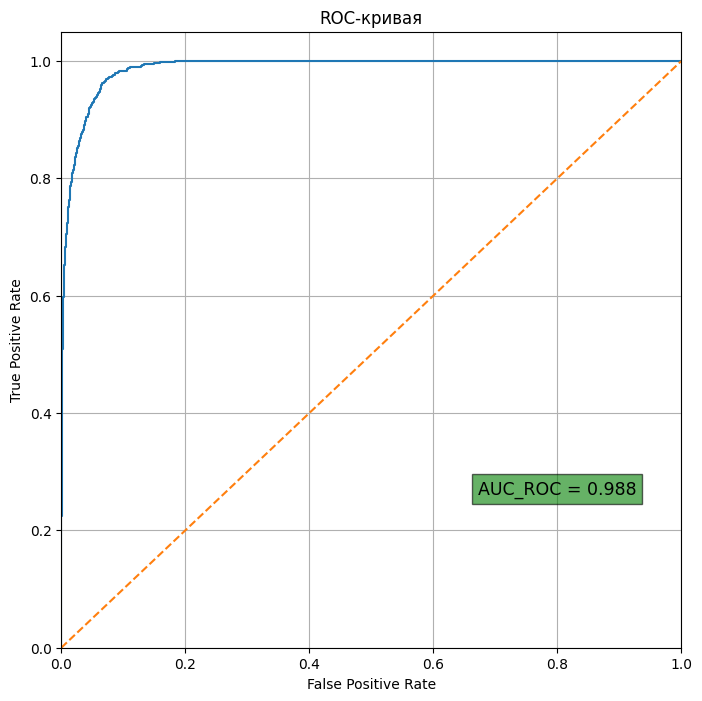

,predicted 0,predicted 1
actual 0,39960,91
actual 1,306,339


In [ ]:
probabilities_one_test = probs_days[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
fpr, tpr, thresholds = roc_curve(y_val_days, probabilities_one_test)
auc_roc = roc_auc_score(y_val_days, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(y_val_days, predict_test)

### Примечание
Не очень хорошо справляется с классом 1.

In [ ]:
importances = model_cat.feature_importances_
df_importances = pd.DataFrame(index=x_train_days[cols].columns, columns=['importance'], data=importances)

df_importances.sort_values(by='importance',ascending=False).head(50)

,importance
ost_prob,33.430690
plan_rem_count,17.444795
plan_days,11.857462
dep_days,2.829645
fr_id,2.354813
outage_days,2.152160
srok_sl_days,1.938864
age_days,1.902631
kap_days,1.651006
id_road_dest,1.622630


### Примечание
Интересно, что в топе находится признак - дни простоя.

In [ ]:
del x_train_days, x_val_days, y_train_days

#### Месяц
Всё так же как и выше

In [ ]:
x_train_month , x_val_month, y_train_month, y_val_month = train_test_split(df.drop(['target_month', 'target_day'], axis=1), df['target_month'],
                                                       test_size=0.3, random_state=28064212, stratify=df['target_month'])

In [ ]:
model_cat = CatBoostClassifier(loss_function='Logloss',
                               depth = 6,
                               iterations=4000,
                               verbose=100,
                               cat_features=cat_features,
                               early_stopping_rounds=300,
                               random_seed = 28064212,
                               task_type='GPU')


In [ ]:
# предсказание вероятностей
model_cat.fit(x_train_month[cols], y_train_month,
              eval_set = (x_val_month[cols], y_val_month)
              )
probs_month = model_cat.predict_proba(x_val_month[cols])

Learning rate set to 0.027238
0:	learn: 0.6308478	test: 0.6311834	best: 0.6311834 (0)	total: 112ms	remaining: 7m 27s
100:	learn: 0.0632347	test: 0.0607758	best: 0.0607758 (100)	total: 4.67s	remaining: 3m
200:	learn: 0.0564493	test: 0.0548613	best: 0.0548613 (200)	total: 7.66s	remaining: 2m 24s
300:	learn: 0.0538185	test: 0.0530448	best: 0.0530448 (300)	total: 18.9s	remaining: 3m 52s
400:	learn: 0.0517528	test: 0.0514668	best: 0.0514668 (400)	total: 22.6s	remaining: 3m 22s
500:	learn: 0.0501779	test: 0.0506813	best: 0.0506813 (500)	total: 25.7s	remaining: 2m 59s
600:	learn: 0.0490931	test: 0.0499687	best: 0.0499687 (600)	total: 28.9s	remaining: 2m 43s
700:	learn: 0.0481309	test: 0.0495681	best: 0.0495681 (700)	total: 37.9s	remaining: 2m 58s
800:	learn: 0.0470484	test: 0.0491431	best: 0.0491431 (800)	total: 43.4s	remaining: 2m 53s
900:	learn: 0.0460638	test: 0.0487999	best: 0.0487985 (898)	total: 48.2s	remaining: 2m 45s
1000:	learn: 0.0451567	test: 0.0485290	best: 0.0485290 (1000)	total:

In [ ]:
log_loss(y_val_month, probs_month)

0.04580691654175159

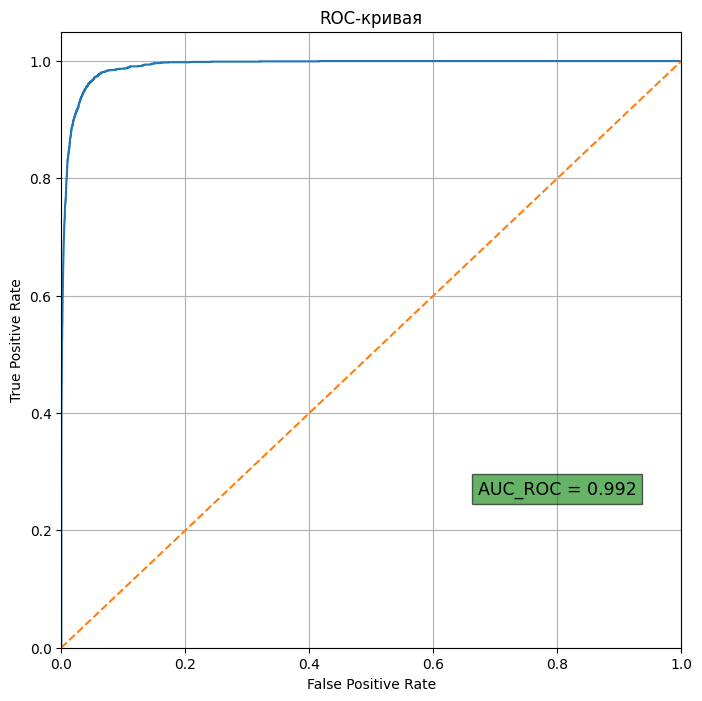

,predicted 0,predicted 1
actual 0,38376,327
actual 1,405,1588


In [ ]:
probabilities_one_test = probs_month[:, 1]
predict_test = probabilities_one_test>0.5
#roc-кривая
fpr, tpr, thresholds = roc_curve(y_val_month, probabilities_one_test)
auc_roc = roc_auc_score(y_val_month, probabilities_one_test)
graph(fpr,tpr,auc_roc)
# матрица ошибок
conf_matrix(y_val_month, predict_test)

### Примечание
Здесь справляется с классом 1 гораздо лучше

In [ ]:
importances = model_cat.feature_importances_
df_importances = pd.DataFrame(index=x_train_month[cols].columns, columns=['importance'], data=importances)

df_importances.sort_values(by='importance',ascending=False)[:10]

,importance
ost_prob,33.303400
plan_rem_count,12.673611
plan_days,9.264623
wagnum,6.130679
outage_days,4.231053
sum_naval,2.355415
dep_days,2.160880
age_days,1.829229
kap_days,1.797698
fr_id,1.443608


### Примечание
Опять же, дни простоя в топе

## Метрика и подбор порога классификации

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
preds_month = probs_month[:, 1]
preds_month = preds_month>0.5

preds_days = probs_days[:, 1]
preds_days = preds_days>0.5


score_month = f1_score(y_val_month, preds_month)
score_day = f1_score(y_val_days, preds_days)
# Посчитаем метрику с весом для двух таргетов
score = 0.5 * score_month + 0.5 * score_day
score

0.7216947942205613

In [ ]:
best_score = 0
best_tresh_month = 0
best_tresh_day = 0

for tresh_month in np.linspace(0,1,11):
    preds_month = probs_month[:, 1]
    preds_month = preds_month > tresh_month

    for tresh_day in np.linspace(0,1,11):
        preds_days = probs_days[:, 1]
        preds_days = preds_days > tresh_day

        score_month = f1_score(y_val_month, preds_month)
        score_day = f1_score(y_val_days, preds_days)
        # Посчитаем метрику с весом для двух таргетов
        score = 0.5 * score_month + 0.5 * score_day

        if score > best_score:
          best_score = score
          best_tresh_month = tresh_month
          best_tresh_day = tresh_day



In [ ]:
best_score, best_tresh_month, best_tresh_day

(0.7372147637477826, 0.4, 0.4)

In [ ]:
del x_train_month , x_val_month, y_train_month

In [ ]:
del model_cat

### Тестовые

In [ ]:
%%time
try:
    df_test = pd.read_csv(PATH + '/df_test2.csv')
except:
    df_test = features('2023-03-01', wag_param, wag_prob, pr_rem, tr_rem, kti, freight, stations)


CPU times: user 197 ms, sys: 15.1 ms, total: 213 ms
Wall time: 826 ms


In [ ]:
# код для генерации и склейки признаков из stations

# temp = features_st(month, stations)

# df_test['plan_date'] = pd.to_datetime(df_test['plan_date'])
# cols_st = ['st_border_sign', 'st_sea_sign',
#        'st_river_sign', 'st_car_sign', 'st_ferry_sign',
#        'st_freigh_sign']
# cols_new = [f'send_{k}' for k in cols_st]
# cols_st.extend(cols_new)
# cols_st = [f'sum_{k}' for k in cols_st]
# cols_st.extend(['plan_date', 'wagnum'])

# df_test = df_test.merge(temp[cols_st],
#               how='left', left_on=['plan_date', 'wagnum'], right_on=['plan_date', 'wagnum'])

# df_test.to_csv(PATH + '/df_test2.csv')

In [ ]:
y_predict = pd.read_csv(PATH +'/target/y_predict.csv').convert_dtypes()
y_predict_example = pd.read_csv(PATH +'/target/y_predict_submit_example.csv').convert_dtypes()

In [ ]:
df_test.shape

(33977, 89)

In [ ]:
# отбросим лишние вагоны
df_test = df_test[df_test['wagnum'].isin(y_predict['wagnum'])]

In [ ]:
df_test = fill(df_test)

## Обучение на всей выборке и классфикация

In [ ]:
model_cat = CatBoostClassifier(loss_function='Logloss',
                               depth = 6,
                               iterations=3000,
                               verbose=100,
                               cat_features=cat_features,
                               random_seed = 28064212,
                               task_type='GPU'
                               )

In [ ]:
# 'target_month', 'target_day'
model_cat.fit(df[cols], df['target_day'])
test_days_probs = model_cat.predict_proba(df_test[cols])

Learning rate set to 0.009616
0:	learn: 0.6693515	total: 58.6ms	remaining: 2m 55s
100:	learn: 0.0538846	total: 3.61s	remaining: 1m 43s
200:	learn: 0.0364707	total: 9.43s	remaining: 2m 11s
300:	learn: 0.0321082	total: 14.2s	remaining: 2m 7s
400:	learn: 0.0300537	total: 17.8s	remaining: 1m 55s
500:	learn: 0.0290957	total: 21.2s	remaining: 1m 45s
600:	learn: 0.0285323	total: 28.3s	remaining: 1m 52s
700:	learn: 0.0281035	total: 32.1s	remaining: 1m 45s
800:	learn: 0.0277679	total: 35.5s	remaining: 1m 37s
900:	learn: 0.0274745	total: 39.9s	remaining: 1m 33s
1000:	learn: 0.0271756	total: 46.1s	remaining: 1m 32s
1100:	learn: 0.0268508	total: 49.6s	remaining: 1m 25s
1200:	learn: 0.0266103	total: 53.1s	remaining: 1m 19s
1300:	learn: 0.0264170	total: 59.1s	remaining: 1m 17s
1400:	learn: 0.0262213	total: 1m 4s	remaining: 1m 13s
1500:	learn: 0.0259696	total: 1m 7s	remaining: 1m 7s
1600:	learn: 0.0257778	total: 1m 11s	remaining: 1m 2s
1700:	learn: 0.0255806	total: 1m 18s	remaining: 59.8s
1800:	learn

In [ ]:
model_cat = CatBoostClassifier(loss_function='Logloss',
                               depth = 6,
                               iterations=4000,
                               verbose=100,
                               cat_features=cat_features,
                               random_seed = 28064212,
                               task_type='GPU'
                               )
model_cat.fit(df[cols], df['target_month'])
test_month_probs = model_cat.predict_proba(df_test[cols])

Learning rate set to 0.007431
0:	learn: 0.6744570	total: 63.8ms	remaining: 4m 15s
100:	learn: 0.1118610	total: 4.13s	remaining: 2m 39s
200:	learn: 0.0680523	total: 10.3s	remaining: 3m 15s
300:	learn: 0.0566533	total: 13.9s	remaining: 2m 50s
400:	learn: 0.0513966	total: 17.4s	remaining: 2m 36s
500:	learn: 0.0477060	total: 23.1s	remaining: 2m 41s
600:	learn: 0.0459407	total: 28.3s	remaining: 2m 39s
700:	learn: 0.0442467	total: 31.8s	remaining: 2m 29s
800:	learn: 0.0434065	total: 35.2s	remaining: 2m 20s
900:	learn: 0.0422828	total: 42.3s	remaining: 2m 25s
1000:	learn: 0.0414474	total: 45.8s	remaining: 2m 17s
1100:	learn: 0.0403368	total: 49.2s	remaining: 2m 9s
1200:	learn: 0.0394543	total: 53.3s	remaining: 2m 4s
1300:	learn: 0.0385300	total: 59.9s	remaining: 2m 4s
1400:	learn: 0.0378809	total: 1m 3s	remaining: 1m 57s
1500:	learn: 0.0372488	total: 1m 6s	remaining: 1m 51s
1600:	learn: 0.0366306	total: 1m 12s	remaining: 1m 48s
1700:	learn: 0.0362616	total: 1m 17s	remaining: 1m 44s
1800:	lear

In [ ]:
preds = df_test[['wagnum']]

### Разметка с учетом подобранных порогов классификации

In [ ]:
test_month = test_month_probs[:, 1]
test_month = test_month>best_tresh_month

test_days = test_days_probs[:, 1]
test_days = test_days>best_tresh_day

preds['target_month'] = test_month
preds['target_day'] = test_days

preds['target_month'] = preds['target_month'].astype('int')
preds['target_day'] = preds['target_day'].astype('int')

y_predict = y_predict.merge(preds, how='left', left_on=['wagnum'], right_on=['wagnum'])

In [ ]:
y_predict.target_month.value_counts()

0    31763
1     1944
Name: target_month, dtype: int64

In [ ]:
y_predict[(y_predict['target_day']==1) & (y_predict['target_month']!=1)]

,wagnum,month,target_month,target_day


In [ ]:
y_predict.to_csv('preds_4.csv')